### Data Prep/Feature Eng
* use cross val for tuning and selecting hyperparameters
* use test set at very end on best model
* find optimal complexityq to balance bias variance

### TRY ALL MODELS - but have rationale on why you are trying models
* document the iterative process

### Deliverables
* Contract by monday 2pm mountain time - communication frequency and tangible deadlines
* model completed by monday EOD
* proof of concept that your target and predictors are fit for machine learning classification
* decide as a team if target can be used as is or needs to be transformed
* FSM

### GROUP: Evan, Drew, Mustafa

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [6]:
df_var = pd.read_csv('../data/training_set_features.csv')
df_tar = pd.read_csv('../data/training_set_labels.csv')['seasonal_vaccine']

In [7]:
# Drop Based On Relevance
df_var = df_var.drop(['respondent_id','h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','doctor_recc_h1n1','hhs_geo_region'],axis=1)

In [8]:
percent_nan = df_var.isna().sum() / df_var.shape[0] * 100
percent_nan.map(round)[percent_nan > 10]

health_insurance         46
income_poverty           17
employment_industry      50
employment_occupation    50
dtype: int64

In [9]:
# Drop based on Nan
df_var = df_var.drop(['health_insurance','income_poverty','employment_industry','employment_occupation'],axis=1)

### Train Test Split

In [10]:
X_train,X_test,y_train,y_test = train_test_split(df_var,df_tar,random_state=42)
X_train = X_train.copy(deep=True)

In [11]:
X_train.columns

Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'marital_status', 'rent_or_own', 'employment_status', 'census_msa',
       'household_adults', 'household_children'],
      dtype='object')

In [12]:
# Imputing Majority Columns
imputer_majority = SimpleImputer(strategy='most_frequent')
majority_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                     'behavioral_face_mask', 'behavioral_wash_hands',
                     'behavioral_large_gatherings', 'behavioral_outside_home',
                     'behavioral_touch_face', 'doctor_recc_seasonal',
                     'chronic_med_condition', 'child_under_6_months', 'health_worker',
                     'education', 'rent_or_own', 'marital_status', 'employment_status',
                     'sex'
                  ]

X_train[majority_columns] = imputer_majority.fit_transform(X_train[majority_columns])

In [13]:
# Imputing Opinion Columns
imputer_opinion = SimpleImputer(strategy='median')
opinion_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','household_adults', 'household_children'
                   ]

X_train[opinion_columns] = imputer_opinion.fit_transform(X_train[opinion_columns])

In [14]:
# One Hot Encoding
ohe = OneHotEncoder(drop='first',categories='auto')
ohe_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','age_group','education','race',
                   'employment_status', 'census_msa'
                   ]
ohe_array = ohe.fit_transform(X_train[ohe_columns])

ohe_df = pd.DataFrame(ohe_array.todense(),columns=ohe.get_feature_names(ohe_columns))
ohe_df.reset_index(inplace=True,drop=True)
X_train.reset_index(inplace=True,drop=True)

X_train_ohe = pd.concat([X_train.drop(ohe_columns,axis=1),ohe_df],axis=1,ignore_index=True)
X_train_ohe.columns = list(X_train.drop(ohe_columns,axis=1).columns) + list(ohe_df.columns)

In [15]:
# Ordinal Encoding
# Sex - 0=Female | 1=Male
# Marital Status - 0=Married | 1=Not Married
# Rent or Own - 0=Own | 1=Rent

oe = OrdinalEncoder(categories='auto')
X_train_ohe[['sex','marital_status','rent_or_own']] = oe.fit_transform(X_train[['sex','marital_status','rent_or_own']])

In [16]:
# Scaling Numerical Columns
ss = StandardScaler()
scaled_array = ss.fit_transform(X_train_ohe)
X_train_ohe_scaled = pd.DataFrame(scaled_array,columns=X_train_ohe.columns)

In [17]:
X_train_ohe_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Data columns (total 42 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   behavioral_antiviral_meds             20030 non-null  float64
 1   behavioral_avoidance                  20030 non-null  float64
 2   behavioral_face_mask                  20030 non-null  float64
 3   behavioral_wash_hands                 20030 non-null  float64
 4   behavioral_large_gatherings           20030 non-null  float64
 5   behavioral_outside_home               20030 non-null  float64
 6   behavioral_touch_face                 20030 non-null  float64
 7   doctor_recc_seasonal                  20030 non-null  float64
 8   chronic_med_condition                 20030 non-null  float64
 9   child_under_6_months                  20030 non-null  float64
 10  health_worker                         20030 non-null  float64
 11  sex            

### Logistic Regression Model

In [18]:
# Dummy Classifier
dc = DummyClassifier(strategy='most_frequent',random_state=42)
dc.fit(X_train_ohe_scaled,y_train)
cv_scores = cross_val_score(dc,X_train_ohe_scaled,y_train,cv=5)
cv_scores

array([0.5312032 , 0.5312032 , 0.5312032 , 0.53095357, 0.53095357])

In [19]:
# Logreg with lasso
logreg_l1 = LogisticRegression(penalty='l1',random_state=42,solver='liblinear')
logreg_l1.fit(X_train_ohe_scaled,y_train)
cv_scores_l1 = cross_val_score(logreg_l1,X_train_ohe_scaled,y_train,cv=5)
cv_scores_l1

array([0.77808288, 0.76684973, 0.77508737, 0.77259111, 0.78207688])

In [20]:
param_grid = {
    'C': np.linspace(1e-5,1,50),
    'solver': ['liblinear','saga'],
    'penalty': ['l1']
}

gs_logreg_l1 = GridSearchCV(logreg_l1, param_grid, cv=3)
gs_logreg_l1.fit(X_train_ohe_scaled, y_train)

gs_logreg_l1.best_params_

{'C': 0.08164183673469387, 'penalty': 'l1', 'solver': 'saga'}

In [21]:
# logreg with ridge
logreg_l2 = LogisticRegression(penalty='l2',random_state=42,solver='liblinear',C=0.02139)
logreg_l2.fit(X_train_ohe_scaled,y_train)
cv_scores_l2 = cross_val_score(logreg_l2,X_train_ohe_scaled,y_train,cv=5)
cv_scores_l2.mean()

0.7744882675986021

In [22]:
param_grid = {
    'C': np.linspace(.001,1,50),
    'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
    'penalty': ['l2']
}

gs_logreg_l2 = GridSearchCV(logreg_l2, param_grid, cv=3)
gs_logreg_l2.fit(X_train_ohe_scaled, y_train)

gs_logreg_l2.best_params_

{'C': 0.021387755102040818, 'penalty': 'l2', 'solver': 'liblinear'}

In [23]:
cv_scores_l1.mean() - cv_scores_l2.mean()

0.00044932601098357505

In [24]:
logreg_l1.predict(X_train_ohe_scaled)

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
coef_list = []
for x in zip(list(X_train_ohe.columns),logreg_l1.coef_[0]):
    coef_list.append(x)

coef_list.sort(key=lambda x: x[1],reverse=True)
coef_list

[('opinion_seas_vacc_effective_5.0', 0.7895629852287955),
 ('opinion_seas_risk_4.0', 0.7814216507355733),
 ('opinion_seas_risk_5.0', 0.6759196864639988),
 ('age_group_65+ Years', 0.6258876567660814),
 ('doctor_recc_seasonal', 0.606447949907097),
 ('opinion_seas_risk_2.0', 0.39309982979048824),
 ('opinion_seas_vacc_effective_4.0', 0.32848145984424687),
 ('age_group_55 - 64 Years', 0.26590198076943483),
 ('health_worker', 0.26420187735522555),
 ('opinion_seas_risk_3.0', 0.22917071688665328),
 ('age_group_45 - 54 Years', 0.15695443014154328),
 ('race_White', 0.13754281118592937),
 ('education_College Graduate', 0.13416821241358085),
 ('behavioral_touch_face', 0.12047832315361204),
 ('race_Other or Multiple', 0.09238317164274469),
 ('opinion_seas_vacc_effective_3.0', 0.08523451061062157),
 ('chronic_med_condition', 0.08148016633161893),
 ('age_group_35 - 44 Years', 0.07212442773867322),
 ('behavioral_wash_hands', 0.0477771110291126),
 ('race_Hispanic', 0.0372772382132341),
 ('education_Som

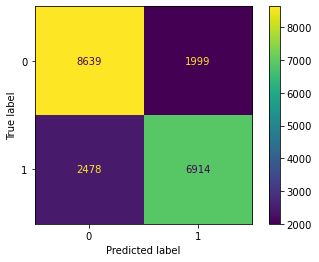

In [26]:
plot_confusion_matrix(logreg_l1,X_train_ohe_scaled,y_train)

In [27]:
top_5_list = [x[0] for x in coef_list[:5]]
bot_5_list = [x[0] for x in coef_list[-5:]]
top_bot_list = top_5_list + bot_5_list

In [28]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_ohe_scaled[top_bot_list],y_train)

KNeighborsClassifier(n_neighbors=11)

In [29]:
cv_scores_knn = cross_val_score(knn,X_train_ohe_scaled[top_bot_list],y_train,cv=5)
cv_scores_knn.mean()

0.7421867199201199

In [30]:
baye = MultinomialNB()
baye.fit(X_train_ohe,y_train)

MultinomialNB()

In [31]:
baye.score(X_train_ohe,y_train)

0.7406889665501747

In [32]:
cv_scores_knn = cross_val_score(baye,X_train_ohe,y_train,cv=5)
cv_scores_knn.mean()

0.7393909136295557

In [33]:
roc_auc_score(y_train,logreg_l1.predict(X_train_ohe_scaled))

0.7741235855966828

In [34]:
logreg_l1.predict(X_train_ohe_scaled)

array([0, 1, 0, ..., 0, 0, 0])

In [35]:
precision = 6914 / (6914+1999)
recall = 6914 / (6914+2478)
2*precision*recall/(precision+recall)

0.755422015842666

In [36]:
# Recursive Feature Selection
cv_rfe = []
keep_lists = []
max_features = 20
for n in range(1,max_features+1):
    num_features_to_select = n
    lr_rfe = LogisticRegression(penalty='l1',random_state=42,solver='liblinear')
    select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
    select.fit(X=X_train_ohe_scaled, y=y_train)
    feature_list = [(k,v) for k,v in zip(X_train_ohe_scaled.columns,select.support_)]
    current_keep_list = []
    for k,v in feature_list:
        if v:
            current_keep_list.append(k)
    
    current_cv = cross_val_score(lr_rfe,X_train_ohe[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

    cv_rfe.append(current_cv)
    keep_lists.append(current_keep_list)
    

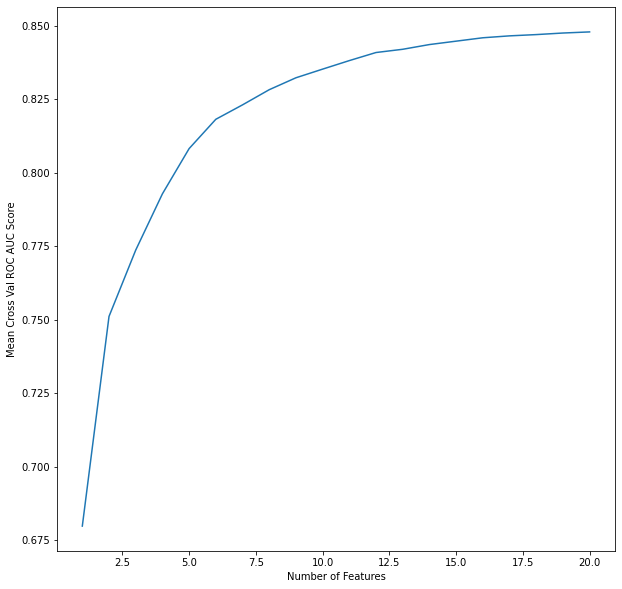

In [37]:
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(range(1,max_features+1),cv_rfe)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Mean Cross Val ROC AUC Score')
plt.show()

In [38]:
logreg_final = LogisticRegression(penalty='l1',random_state=42,solver='saga',C = 0.08164183673469387)
logreg_final.fit(X_train_ohe_scaled[keep_lists[-1]],y_train)
cross_val_score(lr_rfe,X_train_ohe[keep_lists[-1]],y_train,cv=5,scoring='roc_auc').mean()

0.8480905723357626

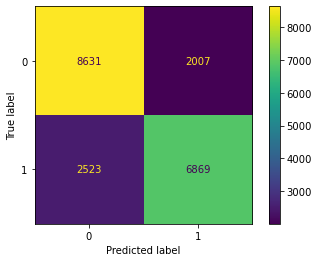

In [39]:
plot_confusion_matrix(logreg_final,X_train_ohe_scaled[keep_lists[-1]],y_train)

In [40]:
logreg_final.score(X_train_ohe_scaled[keep_lists[-1]],y_train)

0.7738392411382926